In [1]:
import os
import pandas as pd
import numpy as np
import random
from deap import base, creator, tools, algorithms

np.random.seed(42)  # for reproducibility
# Get the current working directory
current_directory = os.getcwd()

# Construct the relative path to prediction RUL file
rul_filename = "RUL_consultancy_predictions_A3-2.csv"
rul_path = os.path.join(current_directory, rul_filename)

# Read the CSV file
rul_df = pd.read_csv(rul_path, delimiter=';')
print(rul_df)


    RUL   id
0   135    1
1   125    2
2    63    3
3   100    4
4   103    5
..  ...  ...
95  140   96
96  109   97
97   87   98
98  127   99
99   24  100

[100 rows x 2 columns]


In [2]:
# Define constants
M = len(rul_df) # number of engines
G = 4 # Total number of teams (2 type A, 2 type B)
T = 30 # Planning horizon in days
MAX_DAILY_COST = 250

In [3]:
# Define maintenance times for teams A and B
maintenance_duration_a = [4 if i < 20 else 3 if 20 <= i < 55 else 2 if 55 <= i < 80 else 8 for i in range(1, M + 1)]
maintenance_duration_b = [time_a + 1 if i < 25 else time_a + 2 if 25 <= i < 70 else time_a + 1 for i, time_a in enumerate(maintenance_duration_a, start=1)]


# Define engine costs
engine_costs = [4 if i < 21 else 3 if 21 <= i < 31 else 2 if 31 <= i < 46 else 5 if 46 <= i < 81 else 6 for i in range(1, M + 1)]



In [4]:
def generate_random_schedule(T):
    individual = []
    # Track the availability of each team (A and B) on each day
    team_availability = {day: {'A': 0, 'B': 0} for day in range(1, T + 1)}
    
    # Apply filter to  allocate teams to engines that have a predicted safety due date of less than T = 30.

    filtered_df = rul_df[rul_df['RUL'] <= T].copy()
    engine_ids = list(filtered_df['id'])
    random.shuffle(engine_ids)
    
    # print("Engine IDs:", engine_ids)
    
    # Randomly assign teams to engines within the planning horizon
    for engine_id in engine_ids:
        engine_index = engine_id - 1
        # print("\nProcessing Engine ID:", engine_id)
    
        team_type = np.random.choice(['A', 'B'])  # Assume team type is A for this example
        # print("Selected Team Type:", team_type)
    
        # Determine maintenance duration based on team type
        maintenance_days = maintenance_duration_a[engine_index] if team_type == 'A' else maintenance_duration_b[engine_index]
        # print("Maintenance Days Required:", maintenance_days)
    
        valid_start_dates = []

        # Search for valid start dates with continuous available days for maintenance duration
        for start_day in range(1, T - maintenance_days + 2):
            is_valid = True
            for day in range(start_day, start_day + maintenance_days):
                if team_availability[day][team_type] >= 2:  # Check if max team limit is exceeded on any day
                    is_valid = False
                    break
            if is_valid:
                valid_start_dates.append(start_day)
     
        # print("Team Availability:", team_availability)
        # print("Valid Start Dates:", valid_start_dates)
    
        
        if not valid_start_dates:
            # print("No valid start date found. Skipping this engine.")
            continue
           
                    
        start_day = np.random.choice(valid_start_dates)
        end_day = start_day + maintenance_days - 1
    
        # print("Selected Start Date:", start_date)
        # print("Selected End Date:", end_date)
    
        # Update team availability for the selected team and days
        for day in range(start_day, end_day + 1):
            team_availability[day][team_type] += 1
    
        # print("Team Availability Updated:", team_availability)
    
    
        # RUL = filtered_df.loc[filtered_df['id'] == engine_id, 'RUL'].values[0]
        # safety_due_date = RUL
        # # print("Safety Due Date:", safety_due_date)
        # 
        # 
        # 
        # if end_date > safety_due_date:
        #     penalty_cost_value = penalty_cost(engine_costs[engine_id - 1], end_date - safety_due_date)
        # else:
        #     penalty_cost_value = 0
    
        # print("Penalty Cost Value:", penalty_cost_value)
    
        # Append to individual list
        individual.append((engine_index, team_type, start_day))
        # individual.append({
        #     'Engine_id': engine_id,
        #     'Team': team_type, 
        #     'Safety_due_date': safety_due_date,
        #     'Start_date': start_date,
        #     'End_date': end_date,
        #     'Penalty_cost': penalty_cost_value
        # })
    return individual

# Define the problem as a minimization problem
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
# Initialization functions for individual and population.
def init_individual(T):
    return creator.Individual(generate_random_schedule(T))

def init_population(size, T):
    return [init_individual(T) for _ in range(size)]

In [5]:
# # Define the problem as a minimization problem
# creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
# creator.create("Individual", list, fitness=creator.FitnessMin)

# filtered_df = rul_df[rul_df['RUL'] <= T].copy()
# # Initialization functions for individual and population.
# def init_individual(T):
#     ''' Assigns teams to engines randomly '''
#     return creator.Individual([(engine_index, random.choice(['A', 'B']), random.choice(range(1, T+1))) for engine_index in filtered_df.index])
# 
# def init_population(size, T):
#     return [init_individual(T) for _ in range(size)]


# Define the fitness function
def calculate_penalty(engine_index, start_day, team_type):
    RUL = rul_df.loc[engine_index, 'RUL']
    safety_due_date = RUL
    maintenance_days = maintenance_duration_a[engine_index] if team_type == 'A' else maintenance_duration_b[engine_index]

    end_day = start_day + maintenance_days - 1
    penalty = 0

    if end_day> safety_due_date:
        overdue_days = end_day - safety_due_date
        penalty = min(MAX_DAILY_COST, engine_costs[engine_index] * overdue_days ** 2)

    return penalty

    
def evaluate(individual):
    total_penalty = 0
    for engine_index, team_type, start_day in individual:
        penalty = calculate_penalty(engine_index, start_day, team_type)
        total_penalty += penalty

    return (total_penalty,)


    
def feasible(individual):
    """Feasibility function for the individual. Returns True if feasible False
    otherwise."""
    team_availability = {day: {'A': 0, 'B': 0} for day in range(1, T + 1)}
    unique_engines = set()
    # Constraints
    for engine_index, team_type, start_day in individual:
        # Every engine can be maintained at most once.
        if engine_index in unique_engines:
            return False

        maintenance_days = maintenance_duration_a[engine_index] if team_type == 'A' else maintenance_duration_b[engine_index]
        end_day = start_day + maintenance_days - 1
        # Incomplete schedules are not allowed. 
        if end_day > T:
            return False
        # A team can maintain one engine at a time
        for day in range(start_day, end_day + 1):
            if team_availability[day][team_type] >= 2:
                return False
            team_availability[day][team_type] += 1

        unique_engines.add(engine_index)

    return True


In [28]:
# Register genetic algorithm operators
toolbox = base.Toolbox()
toolbox.register("individual", init_individual)
toolbox.register("population", init_population)
toolbox.register("evaluate", evaluate)
toolbox.decorate("evaluate", tools.DeltaPenalty(feasible, 50000))
toolbox.register("mate", tools.cxTwoPoint)
# toolbox.register("mutate", tools.mutShuffleIndexes(individual, indpb=0.01))
toolbox.register("select", tools.selTournament, tournsize=10)

# Evolution parameters
ngen = 50  # Generations

# Create the population
pop = toolbox.population(size=1000, T=T)
# Hall of Fame and Statistics
hof = tools.ParetoFront()
stats = tools.Statistics(lambda ind: ind.fitness.values)

# Register statistics
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

In [29]:
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.0,
                                   ngen=ngen, stats=stats, halloffame=hof)

gen	nevals	avg      	std           	min   	max    
0  	1000  	[1468.67]	[333.93814263]	[488.]	[2715.]
1  	692   	[34496.705]	[22809.35370483]	[488.]	[50000.]
2  	710   	[35526.531]	[22428.69881382]	[476.]	[50000.]
3  	694   	[32433.41] 	[23626.89689819]	[466.]	[50000.]
4  	710   	[29043.2]  	[24426.09424312]	[466.]	[50000.]
5  	704   	[13830.753]	[21941.03362182]	[466.]	[50000.]
6  	700   	[13910.694]	[22003.89736393]	[466.]	[50000.]
7  	686   	[15628.716]	[22823.21212063]	[458.]	[50000.]
8  	704   	[7203.086] 	[16979.50561496]	[458.]	[50000.]
9  	700   	[465.568]  	[1.80814159]    	[458.]	[466.]  
10 	666   	[462.872]  	[3.90379508]    	[458.]	[466.]  
11 	700   	[458.048]  	[0.61781551]    	[458.]	[466.]  
12 	712   	[458.]     	[0.]            	[458.]	[458.]  
13 	694   	[458.]     	[0.]            	[458.]	[458.]  
14 	702   	[458.]     	[0.]            	[458.]	[458.]  
15 	662   	[458.]     	[0.]            	[458.]	[458.]  
16 	684   	[458.]     	[0.]            	[458.]	[458.]  
17

In [30]:
# Best Solution
best_solution = tools.selBest(pop, 1)[0]
print("")
# print(best_solution)
print("[{}] best_score: {}".format(logbook[-1]['gen'], logbook[-1]['min'][0]))

# Function to save best individual to CSV
def save_best_individual_to_csv(best_individual, filename):
    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(best_individual)
    print("TO CSV")
    print(df)
    # Save the DataFrame to a CSV file
#     df.to_csv(filename, index=False)
#     print(f"Best individual saved to {filename}")

# Save the best solution to a CSV file
save_best_individual_to_csv(best_solution, 'best_individual.csv')



[50] best_score: 458.0
TO CSV
     0  1   2
0   40  B  11
1   34  A  10
2   81  A  20
3   91  B  17
4   90  B   2
5   55  B  18
6   89  B  22
7   35  A   9
8   80  B   2
9   39  A  14
10  23  A  18
11  65  A  12
12  76  B  26
13  41  A   6
14  36  A  15


/var/folders/cl/tc2bm4kj1zj4_rj22f8cwb400000gn/T/ipykernel_88641/3325246438.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(front[:,0][1:-1], front[:,1][1:-1], "-bo", c="b")


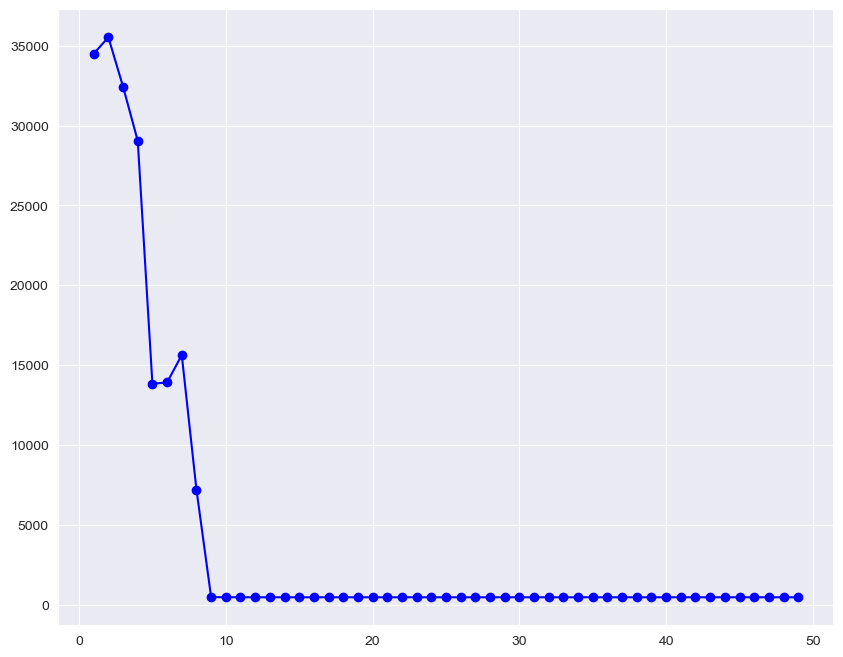

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# History AVG
plt.figure(figsize=(10,8))
front = np.array([(c['gen'], c['avg'][0]) for c in logbook])
plt.plot(front[:,0][1:-1], front[:,1][1:-1], "-bo", c="b")
plt.axis("tight")
plt.show()

In [19]:
import pandas as pd

def count_teams_starting_each_day(schedule_df):
    # Initialize a dictionary to hold the count of teams starting work each day
    days_count = {day: 0 for day in range(1, T + 1)}

    # Iterate through each row in the DataFrame
    for index, row in schedule_df.iterrows():
        start_day = row['start_maintenance']
        if start_day in days_count:
            days_count[start_day] += 1

    # Convert the dictionary to a pandas DataFrame for better readability
    days_count_df = pd.DataFrame(list(days_count.items()), columns=['Day', 'Teams_Starting'])
    
    return days_count_df

# Example usage
# Assume schedule_df is the DataFrame containing the maintenance schedule
schedule_df = pd.DataFrame(best_solution)  # best_solution should be a list of dictionaries
days_count_df = count_teams_starting_each_day(schedule_df)

print(days_count_df)


KeyError: 'start_maintenance'